#Importing the dataset and neccassary libraries. 

In [21]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image

In [23]:
data_flag = 'bloodmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [24]:
DataClass=getattr(medmnist, info['python_class'])

In [25]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [26]:
transform = T.Resize(224)

In [27]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [28]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [29]:
train_df=pd.DataFrame.from_dict(data)
train_df

Image  Labels  is_valid
0      <PIL.Image.Image image mode=RGB size=28x28>       7      True
1      <PIL.Image.Image image mode=RGB size=28x28>       3      True
2      <PIL.Image.Image image mode=RGB size=28x28>       6      True
3      <PIL.Image.Image image mode=RGB size=28x28>       6      True
4      <PIL.Image.Image image mode=RGB size=28x28>       7      True
...                                            ...     ...       ...
13666  <PIL.Image.Image image mode=RGB size=28x28>       3     False
13667  <PIL.Image.Image image mode=RGB size=28x28>       6     False
13668  <PIL.Image.Image image mode=RGB size=28x28>       3     False
13669  <PIL.Image.Image image mode=RGB size=28x28>       1     False
13670  <PIL.Image.Image image mode=RGB size=28x28>       6     False

[13671 rows x 3 columns]

In [30]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

Image  Labels  is_valid
0      <PIL.Image.Image image mode=RGB size=28x28>       6     False
1      <PIL.Image.Image image mode=RGB size=28x28>       7      True
2      <PIL.Image.Image image mode=RGB size=28x28>       5      True
3      <PIL.Image.Image image mode=RGB size=28x28>       2      True
4      <PIL.Image.Image image mode=RGB size=28x28>       1      True
...                                            ...     ...       ...
13666  <PIL.Image.Image image mode=RGB size=28x28>       3      True
13667  <PIL.Image.Image image mode=RGB size=28x28>       6      True
13668  <PIL.Image.Image image mode=RGB size=28x28>       6      True
13669  <PIL.Image.Image image mode=RGB size=28x28>       4      True
13670  <PIL.Image.Image image mode=RGB size=28x28>       6      True

[13671 rows x 3 columns]

# Training Parameters and defining the model.

In [31]:
def get_x(r):
    img=transform(r['Image'])
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [32]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) # black & white
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

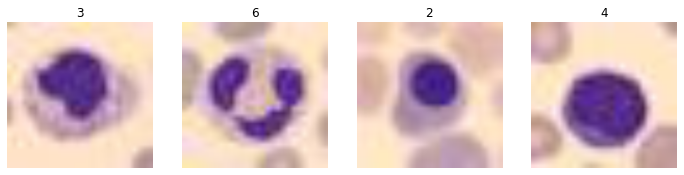

In [33]:
dls = dblock.dataloaders(train_df, bs=32)
dls.show_batch(nrows=1, ncols=4)

In [34]:
learn = vision_learner(dls, resnet101, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
learn.fine_tune(10, base_lr=3e-3, freeze_epochs=4)  

#Evaluating the Model

In [ ]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [37]:
interp.most_confused(min_val=5) # prints (actual label,predicted label,freq of misclassified examples) (freq>=min_value)

[(5, 3, 246),
 (0, 3, 81),
 (6, 3, 73),
 (3, 5, 69),
 (3, 6, 59),
 (2, 3, 44),
 (2, 4, 38),
 (3, 4, 28),
 (5, 4, 25),
 (0, 4, 24),
 (3, 0, 24),
 (4, 3, 21),
 (4, 2, 14),
 (3, 2, 12),
 (4, 5, 12),
 (1, 3, 11),
 (6, 1, 11),
 (2, 6, 8),
 (5, 0, 7),
 (0, 1, 6),
 (1, 0, 6),
 (2, 7, 6),
 (3, 1, 6),
 (0, 6, 5),
 (2, 0, 5),
 (2, 5, 5),
 (6, 0, 5),
 (7, 2, 5)]

In [19]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(transform(test_dataset[i][0]))
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [20]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       244
           1       0.99      0.99      0.99       624
           2       0.98      0.92      0.95       311
           3       0.79      0.90      0.84       579
           4       0.90      0.95      0.92       243
           5       0.90      0.73      0.81       284
           6       0.97      0.96      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.93      3421
   macro avg       0.93      0.91      0.92      3421
weighted avg       0.93      0.93      0.93      3421

